# Imports

In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Black-Scholes Model Initialization

In [38]:
class BlackScholesModel:
    def __init__(self, ticker, expiration_date):
        self.ticker = ticker
        self.expiration_date = expiration_date
        self.S = self._get_current_stock_price()
        self.r = self._get_10yr_treasury_rate() / 100
        self.t = self._get_time_to_expiration()
        self.vol = self._calculate_volatility()

    def _get_current_stock_price(self):
        stock = yf.Ticker(self.ticker)
        return stock.history(period='1d')['Close'].iloc[-1]

    def _get_10yr_treasury_rate(self):
        treasury_ticker = "^TNX"
        end_date = datetime.now()
        start_date = end_date - timedelta(days=1)
        treasury_data = yf.download(treasury_ticker, start=start_date, end=end_date)
        return treasury_data['Close'].iloc[-1]

    def _get_time_to_expiration(self):
        expiration_date = datetime.strptime(self.expiration_date, '%Y-%m-%d')
        return (expiration_date - datetime.now()).days / 365.25

    def _calculate_volatility(self):
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365)
        data = yf.download(self.ticker, start=start_date, end=end_date)
        daily_returns = data['Adj Close'].pct_change().dropna()
        return daily_returns.std() * np.sqrt(252)

    @staticmethod
    def _d1(S, K, t, r, vol):
        return (np.log(S/K) + (r + 0.5 * vol**2) * t) / (vol * np.sqrt(t))

    @staticmethod
    def _d2(S, K, t, r, vol):
        return BlackScholesModel._d1(S, K, t, r, vol) - vol * np.sqrt(t)

    def call_price(self, K):
        d1 = self._d1(self.S, K, self.t, self.r, self.vol)
        d2 = self._d2(self.S, K, self.t, self.r, self.vol)
        return self.S * norm.cdf(d1) - K * np.exp(-self.r * self.t) * norm.cdf(d2)

    def put_price(self, K):
        d1 = self._d1(self.S, K, self.t, self.r, self.vol)
        d2 = self._d2(self.S, K, self.t, self.r, self.vol)
        return K * np.exp(-self.r * self.t) * norm.cdf(-d2) - self.S * norm.cdf(-d1)

    def calculate_greeks(self, option_type='call'):
        if option_type not in ['call', 'put']:
            raise ValueError("option_type must be either 'call' or 'put'")

        def delta(K):
            d1 = self._d1(self.S, K, self.t, self.r, self.vol)
            return norm.cdf(d1) if option_type == 'call' else norm.cdf(d1) - 1

        def gamma(K):
            d1 = self._d1(self.S, K, self.t, self.r, self.vol)
            return norm.pdf(d1) / (self.S * self.vol * np.sqrt(self.t))

        def vega(K):
            d1 = self._d1(self.S, K, self.t, self.r, self.vol)
            return self.S * norm.pdf(d1) * np.sqrt(self.t)

        def theta(K):
            d1 = self._d1(self.S, K, self.t, self.r, self.vol)
            d2 = self._d2(self.S, K, self.t, self.r, self.vol)
            if option_type == 'call':
                return -self.S * norm.pdf(d1) * self.vol / (2 * np.sqrt(self.t)) - self.r * K * np.exp(-self.r * self.t) * norm.cdf(d2)
            else:
                return -self.S * norm.pdf(d1) * self.vol / (2 * np.sqrt(self.t)) + self.r * K * np.exp(-self.r * self.t) * norm.cdf(-d2)

        def rho(K):
            d2 = self._d2(self.S, K, self.t, self.r, self.vol)
            if option_type == 'call':
                return K * self.t * np.exp(-self.r * self.t) * norm.cdf(d2)
            else:
                return -K * self.t * np.exp(-self.r * self.t) * norm.cdf(-d2)

        return delta, gamma, vega, theta, rho

    def fetch_options_data(self):
        ticker = yf.Ticker(self.ticker)
        options_data = ticker.option_chain(self.expiration_date)
        return options_data.calls, options_data.puts

    def analyze_options(self, option_type='call'):
        calls, puts = self.fetch_options_data()
        df = calls if option_type == 'call' else puts
        
        # Create a new DataFrame instead of modifying a slice
        result_df = df[['strike', 'lastPrice', 'volume', 'openInterest']].copy()
        
        result_df['bsmValuation'] = result_df['strike'].apply(self.call_price if option_type == 'call' else self.put_price)
        
        delta, gamma, vega, theta, rho = self.calculate_greeks(option_type)
        result_df['delta'] = result_df['strike'].apply(delta)
        result_df['gamma'] = result_df['strike'].apply(gamma)
        result_df['vega'] = result_df['strike'].apply(vega)
        result_df['theta'] = result_df['strike'].apply(theta)
        result_df['rho'] = result_df['strike'].apply(rho)
        
        return result_df

    def plot_greeks(self, option_type='call'):
        df = self.analyze_options(option_type)
        
        fig, axes = plt.subplots(3, 2, figsize=(15, 20))
        fig.suptitle(f'{self.ticker} {option_type.capitalize()} Option Greeks', fontsize=16)
        
        axes[0, 0].plot(df['strike'], df['bsmValuation'])
        axes[0, 0].set_title('Option Price')
        axes[0, 0].set_xlabel('Strike Price')
        axes[0, 0].set_ylabel('Option Price')
        
        axes[0, 1].plot(df['strike'], df['delta'])
        axes[0, 1].set_title('Delta')
        axes[0, 1].set_xlabel('Strike Price')
        axes[0, 1].set_ylabel('Delta')
        
        axes[1, 0].plot(df['strike'], df['gamma'])
        axes[1, 0].set_title('Gamma')
        axes[1, 0].set_xlabel('Strike Price')
        axes[1, 0].set_ylabel('Gamma')
        
        axes[1, 1].plot(df['strike'], df['vega'])
        axes[1, 1].set_title('Vega')
        axes[1, 1].set_xlabel('Strike Price')
        axes[1, 1].set_ylabel('Vega')
        
        axes[2, 0].plot(df['strike'], df['theta'])
        axes[2, 0].set_title('Theta')
        axes[2, 0].set_xlabel('Strike Price')
        axes[2, 0].set_ylabel('Theta')
        
        axes[2, 1].plot(df['strike'], df['rho'])
        axes[2, 1].set_title('Rho')
        axes[2, 1].set_xlabel('Strike Price')
        axes[2, 1].set_ylabel('Rho')
        
        plt.tight_layout()
        plt.show()

# Output

C:\Users\saumy\AppData\Local\Temp\ipykernel_3636\3447157417.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Black-Scholes Model Analysis for SPY

Analysis Date: 2024-07-10 12:11:33
Option Expiration Date: 2024-09-20

Model Parameters:
Current Stock Price: $558.01
Risk-free Rate: 4.29%
Time to Expiration: 0.19 years
Implied Volatility: 11.08%

Call Options Analysis:
--------------------------------------------------------------------------------
 strike  lastPrice  bsmValuation  delta  gamma    vega    theta     rho
  150.0     398.27      409.2563 1.0000 0.0000  0.0000  -6.3845 28.9159
  155.0     320.00      404.2978 1.0000 0.0000  0.0000  -6.5973 29.8797
  160.0     300.85      399.3394 1.0000 0.0000  0.0000  -6.8101 30.8436
  165.0     297.90      394.3809 1.0000 0.0000  0.0000  -7.0230 31.8074
  170.0     361.08      389.4224 1.0000 0.0000  0.0000  -7.2358 32.7713
  175.0     287.18      384.4640 1.0000 0.0000  0.0000  -7.4486 33.7352
  180.0     368.84      379.5055 1.0000 0.0000  0.0000  -7.6614 34.6990
  185.0     328.56      374.5471 1.0000 0.0000  0.0000  -7.8742 35.6629
  190.0   

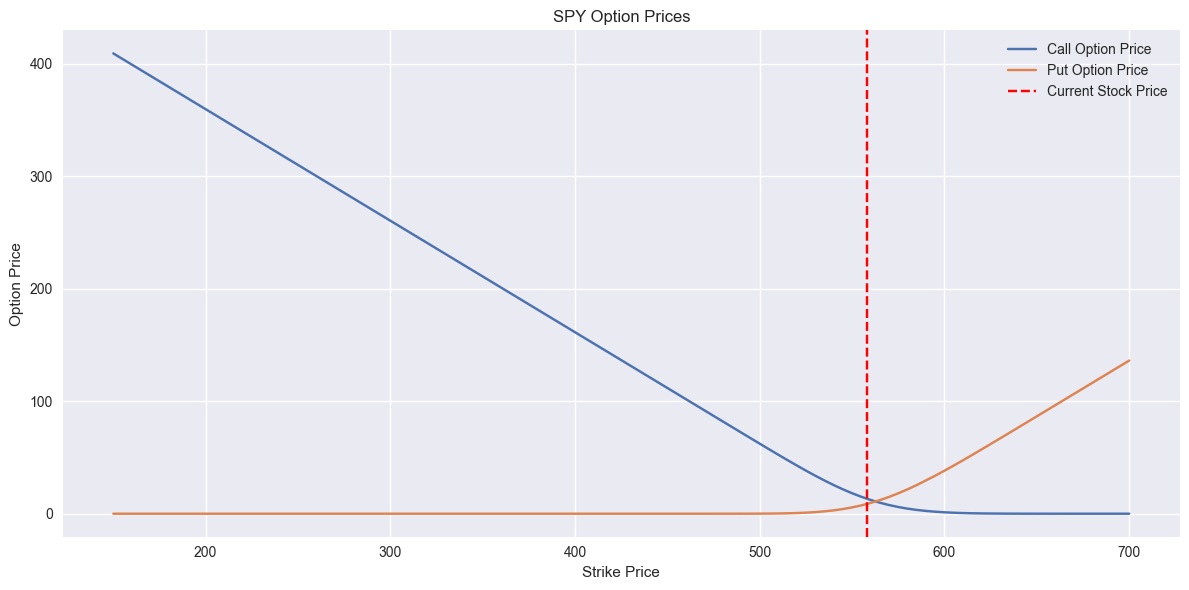

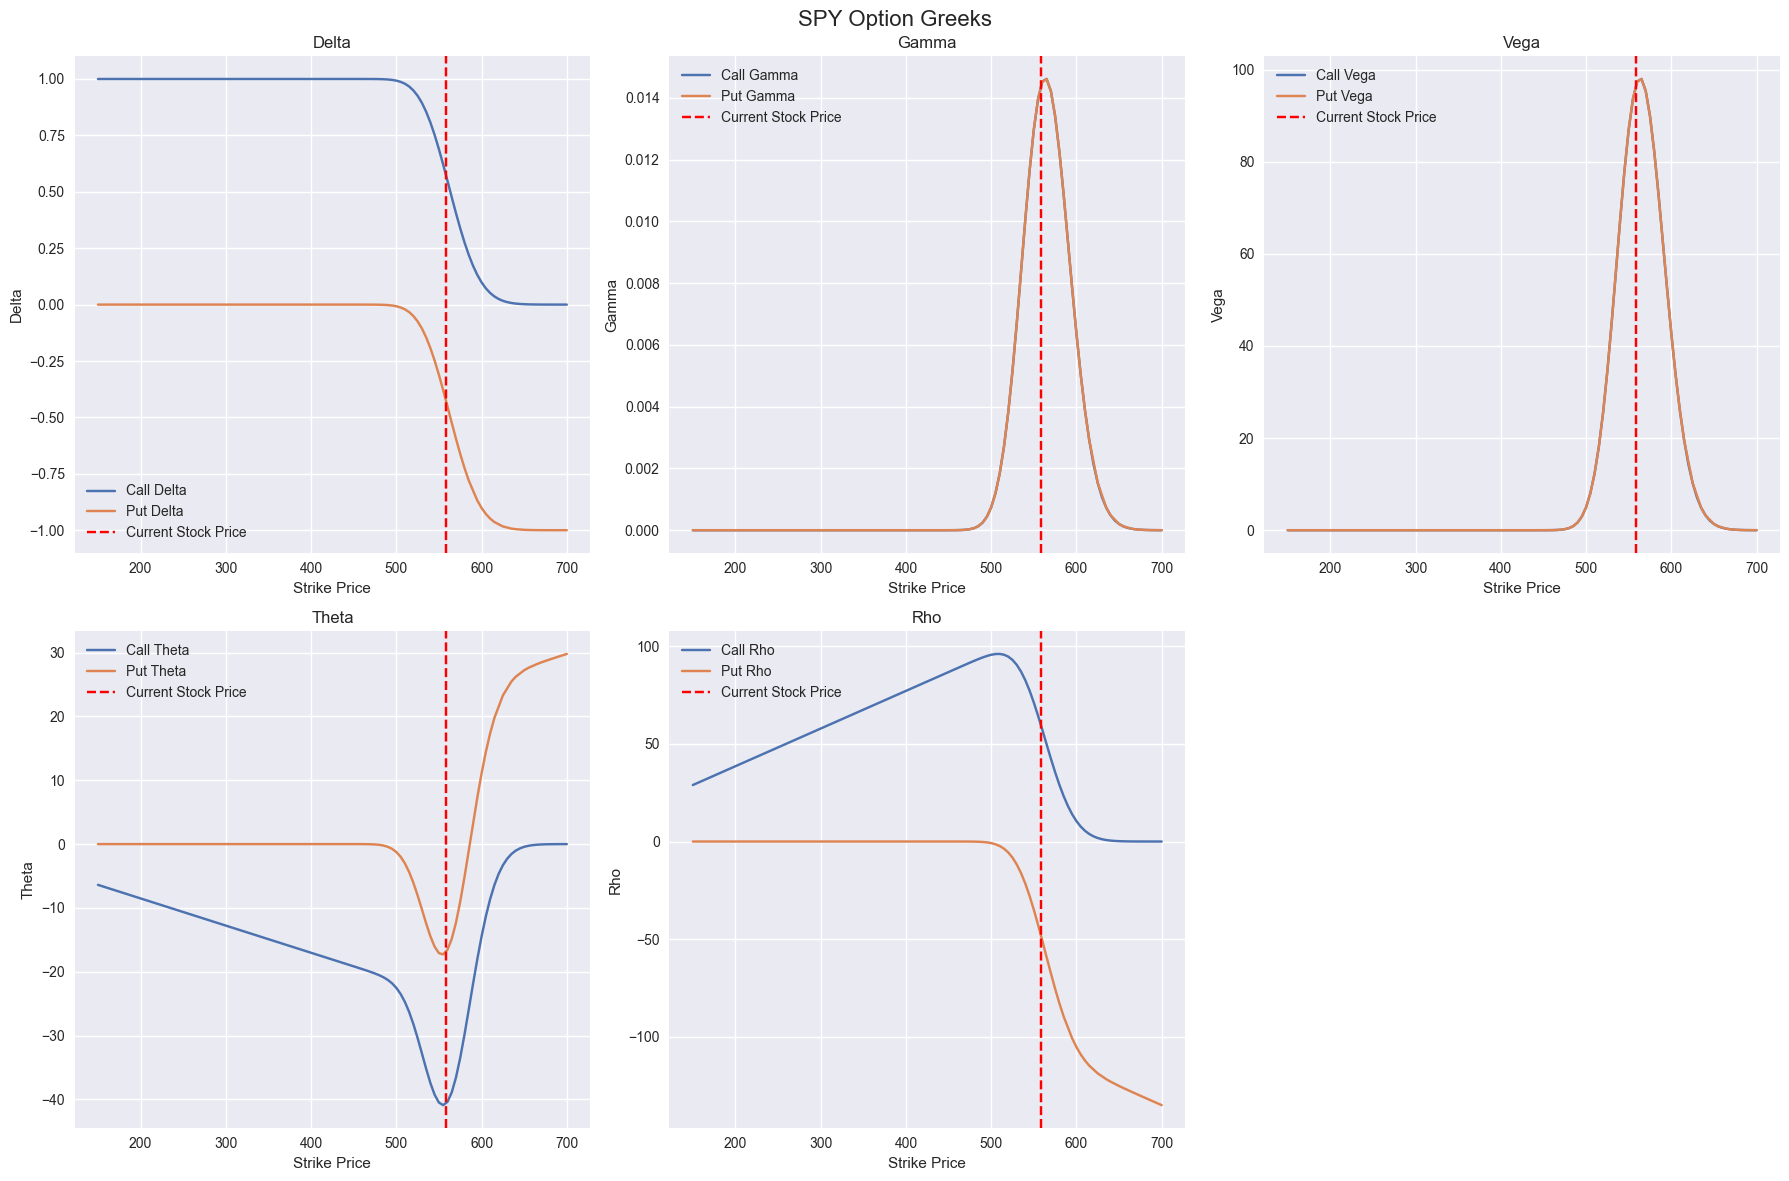


Analysis Complete. Plots have been displayed.


In [39]:
if __name__ == "__main__":
    plt.style.use('seaborn')
    sns.set_palette("deep")
    
    # Initialize the model
    ticker = 'SPY' # Change ticker to whatever you want
    expiration_date = '2024-09-20' # Change expiration date accordingly
    model = BlackScholesModel(ticker, expiration_date)
    
    print("\n" + "="*50)
    print(f"Black-Scholes Model Analysis for {ticker}")
    print("="*50)
    
    print(f"\nAnalysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Option Expiration Date: {expiration_date}")
    print(f"\nModel Parameters:")
    print(f"Current Stock Price: ${model.S:.2f}")
    print(f"Risk-free Rate: {model.r:.2%}")
    print(f"Time to Expiration: {model.t:.2f} years")
    print(f"Implied Volatility: {model.vol:.2%}")
    
    # Analyze options
    call_options = model.analyze_options('call')
    put_options = model.analyze_options('put')
    
    # Function to format and display option analysis
    def display_option_analysis(df, option_type):
        print(f"\n{option_type.capitalize()} Options Analysis:")
        print("-" * 80)
        summary = df[['strike', 'lastPrice', 'bsmValuation', 'delta', 'gamma', 'vega', 'theta', 'rho']]
        summary = summary.round(4)
        pd.set_option('display.max_rows', 10)
        pd.set_option('display.width', 1000)
        print(summary.to_string(index=False))
        pd.reset_option('display.max_rows')
        pd.reset_option('display.width')
    
    display_option_analysis(call_options, 'call')
    display_option_analysis(put_options, 'put')
    
    # Plot option prices
    plt.figure(figsize=(12, 6))
    plt.plot(call_options['strike'], call_options['bsmValuation'], label='Call Option Price')
    plt.plot(put_options['strike'], put_options['bsmValuation'], label='Put Option Price')
    plt.axvline(x=model.S, color='r', linestyle='--', label='Current Stock Price')
    plt.title(f'{ticker} Option Prices')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot Greeks
    def plot_greeks(call_df, put_df):
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'{ticker} Option Greeks', fontsize=16)
        
        greeks = ['delta', 'gamma', 'vega', 'theta', 'rho']
        
        for i, greek in enumerate(greeks):
            ax = axes[i // 3, i % 3]
            ax.plot(call_df['strike'], call_df[greek], label=f'Call {greek.capitalize()}')
            ax.plot(put_df['strike'], put_df[greek], label=f'Put {greek.capitalize()}')
            ax.set_title(f'{greek.capitalize()}')
            ax.set_xlabel('Strike Price')
            ax.set_ylabel(greek.capitalize())
            ax.axvline(x=model.S, color='r', linestyle='--', label='Current Stock Price')
            ax.legend()
            ax.grid(True)
        
        # Remove the unused subplot
        fig.delaxes(axes[1][2])
        
        plt.tight_layout()
        plt.show()
    
    plot_greeks(call_options, put_options)
    
    print("\nAnalysis Complete. Plots have been displayed.")